In [38]:
import keras
import tensorflow as tf
%matplotlib inline
import os, sys
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
print("python:{}, keras:{}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

python:3.5.3 | packaged by conda-forge | (default, May 12 2017, 15:35:12) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)], keras:2.0.0, tensorflow: 1.8.0


In [11]:
# Define some useful functions
def normFtrs(npMtrx):
    # Normalize each feature to be zero mean, unit standard deviation
    nDim=npMtrx.shape
    ftrMns=np.zeros((1,nDim[1]))
    ftrSDs=np.zeros((1,nDim[1]))
    ftrMns[:1,:]=npMtrx.mean(axis=0)
    ftrSDs[:1,:]=npMtrx.std(axis=0)
    
    for a in range(nDim[1]):
        npMtrx[:,a:(a+1)]=(npMtrx[:,a:(a+1)]-ftrMns[0,a])/ftrSDs[0,a]
    
    return ftrMns, ftrSDs

In [36]:
#inFname='/Users/davidgroppe/ONGOING/RNN/ECHO_STATE/LORENZ/lorenzData.mat'
inFname='/Users/davidgroppe/PycharmProjects/LSTM_SZR_PRED/SAMPLE_DATA/lorenzData.mat'
print('Loading: {}'.format(inFname))
mat=sio.loadmat(inFname)
mat.keys()
nTpt=mat['x'].shape[0]
nDim=3
data=np.zeros((nTpt,nDim))
data[:,0:1]=mat['x']
data[:,1:2]=mat['y']
data[:,2:3]=mat['z']
#data=np.diff(data)
print('# of timepoints %d' % nTpt)
print('Pre-normalized data SDs')
print(data.std(axis=0))
# Normalize data to unit standard deviation and zero mean
ftrMns, ftrSDs=normFtrs(data)
print('Post-normalized data SDs')
print(data.std(axis=0))
print('Post-normalized data means')
print(data.mean(axis=0))

Loading: /Users/davidgroppe/PycharmProjects/LSTM_SZR_PRED/SAMPLE_DATA/lorenzData.mat
# of timepoints 100000
Pre-normalized data SDs
[ 9.22327912 10.57418817  9.56750702]
Post-normalized data SDs
[1. 1. 1.]
Post-normalized data means
[ 1.63760019e-15  9.33740307e-16 -1.29873134e-14]


In [13]:
from keras.models import Sequential  
from keras.layers.core import Dense, Activation  
from keras.layers.recurrent import LSTM

in_out_neurons = nDim  
hidden_neurons = 300

model = Sequential()
model.add(LSTM(hidden_neurons, return_sequences=False,
               input_shape=(None, in_out_neurons)))
model.add(Dense(in_out_neurons, input_dim=hidden_neurons))  
model.add(Activation("linear"))  
model.compile(loss="mean_squared_error", optimizer="rmsprop")  

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300)               364800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 903       
_________________________________________________________________
activation_1 (Activation)    (None, 3)                 0         
Total params: 365,703.0
Trainable params: 365,703.0
Non-trainable params: 0.0
_________________________________________________________________


(100000, 3)


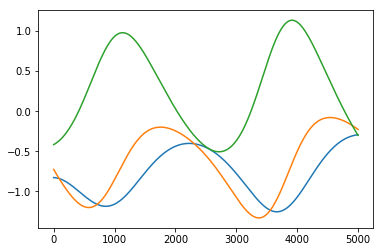

In [37]:
print(data.shape)
n_past=5000
plt.plot(data[:n_past,:])

In [27]:
dX, dY=_load_data(data[:10000,:])

(100000, 3)
(5000, 5000, 3)
(5000, 3)


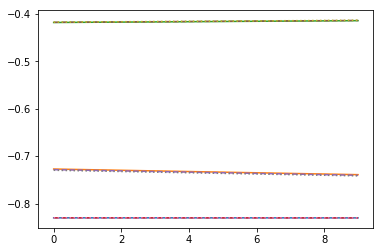

In [32]:
print(data.shape)
print(dX.shape)
print(dY.shape)
plt.figure(1)
plt.clf()
plt.plot(np.squeeze(dX[0,:10,:]))
plt.plot(np.squeeze(dX[1,:10,:]),'--')
plt.plot(np.squeeze(dX[2,:10,:]),':')

In [39]:
def _load_data(data, n_prev = 5000):  
    """
    data should be np array time x var
    data_X= clip x preceding time points x var
    data_Y= clip x var
    """
    docX, docY = [], []
    n_tpt, n_var=data.shape
    n_obs=n_tpt-n_prev
    data_X=np.zeros((n_obs,n_prev,n_var))
    data_Y=np.zeros((n_obs,n_var))
    for i in range(n_obs):
        data_X[i,:,:]=data[i:i+n_prev,:]
        data_Y[i,:]=data[i+n_prev,:]

    return data_X, data_Y

# def _load_data(data, n_prev = 100):  
#     """
#     data should be pd.DataFrame()
#     """

#     docX, docY = [], []
#     for i in range(len(data)-n_prev):
#         docX.append(data.iloc[i:i+n_prev].as_matrix())
#         docY.append(data.iloc[i+n_prev].as_matrix())
#     alsX = np.array(docX)
#     alsY = np.array(docY)

#     return alsX, alsY

def train_test_split(data, test_pptn=0.1):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(data.shape[0] * (1 - test_pptn))

    X_train, y_train = _load_data(data[0:ntrn,:])
    X_test, y_test = _load_data(data[ntrn:,:])

    return (X_train, y_train), (X_test, y_test)

In [ ]:
(X_train, y_train), (X_test, y_test) = train_test_split(data)  # retrieve data

# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
model.fit(X_train, y_train, batch_size=450, epochs=10, validation_split=0.05)  

Train on 80750 samples, validate on 4250 samples
Epoch 1/10
 1350/80750 [..............................] - ETA: 118301s - loss: 0.7163

In [8]:
predicted = model.predict(X_test)  
rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))

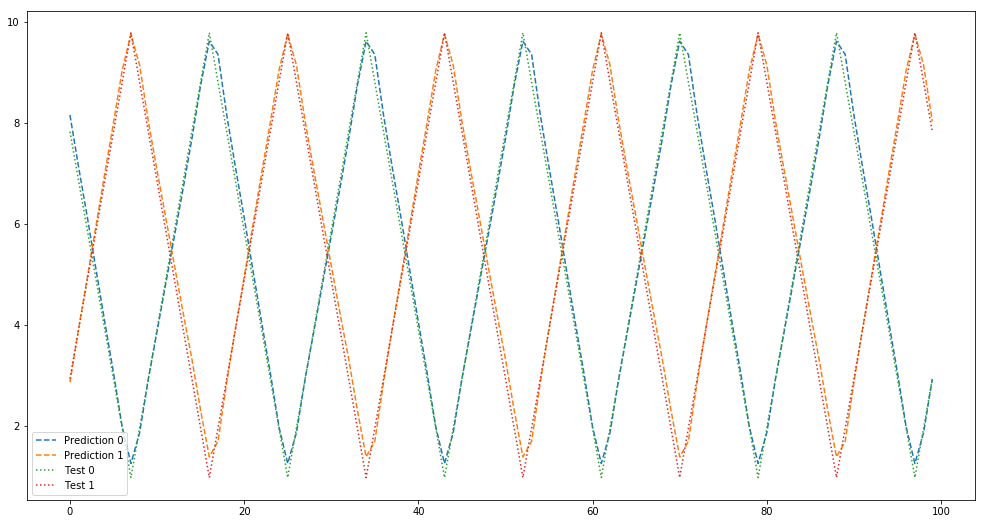

In [9]:
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (17, 9)
plt.plot(predicted[:100][:,0],"--")
plt.plot(predicted[:100][:,1],"--")
plt.plot(y_test[:100][:,0],":")
plt.plot(y_test[:100][:,1],":")
plt.legend(["Prediction 0", "Prediction 1", "Test 0", "Test 1"])